# House Price vs Graduation rate

Focuse on 4-Year Longitudinal Rate (Gr 9-12)

- Data_field='4-Year Longitudinal Rate (Gr 9-12)'
- Data_Level='District'
- Subcategory='Graduates'   ('Graduates and GED', Graduates and TxCHSE)

-> element=['DA3C4X15R','DA3C4X16R','DA3C4X17R','DA3C4X18R','DA3C4X19R','DA3C4X20R','DA3C4X21R']

In [1]:
import pandas as pd
import os
import re
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

# Data process
- Process metric data (graduate rate)
- Process houseprice data
- Combine above 2 data
  - Drop the 2 rows with a high probability of error: after checking the data in these two columns are found to greatly exceed the house price values of the years before and after
- Feature engineering: 
  - Divide into two datasets with 75 as the threshold
  - Create new feautes: based on each group: groupby(['zipcode','DISTRICT','distname'])
- Divide into 3 kinds dataframe:
  - apply to all school years up until 2022
  - apply to all school years up until 2019 (to remove the impact of COVID-19)
  - apply to all school years up until 2022 but focus on the some spefic district

In [2]:
####### Process metric data (graduate rate)
dfs = []

# Loop over the years and read in each DataFrame, cleaning the 'DISTRICT' column
for year in [2017, 2018, 2019, 2021, 2022]:
    df = pd.read_csv('TX_data/TAPR_District/TAPR_'+str(year)+'.csv', na_values=['.'])
    df['DISTRICT'] = df['DISTRICT'].str.replace("'", '').astype('float64')
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])    
    dfs.append(df)

# Merge the DataFrames on the 'DISTRICT' column
merged_df = pd.merge(dfs[0], dfs[1], on='DISTRICT', how='inner')
for df in dfs[2:]:
    merged_df = pd.merge(merged_df, df, on=['DISTRICT'], how='inner')
    
merged_df=merged_df[['DISTRICT']+list(merged_df.columns[merged_df.columns.str.startswith('DA3C4X')])]
merged_df=merged_df.T.drop_duplicates().T
merged_df.columns = [col.replace('_x', '') for col in merged_df.columns]

# Convert
merged_df=merged_df.melt(id_vars='DISTRICT', var_name='year', value_name='DA3C4X')
merged_df['year']='20'+merged_df['year'].str[-3:-1]
merged_df['year']=merged_df['year'].astype(int)
merged_df=merged_df.sort_values(['DISTRICT','year'])

In [3]:
merged_df.head(5)

,DISTRICT,year,DA3C4X
0,1902.0,2015,93.3
1185,1902.0,2016,93.5
2370,1902.0,2017,95.7
3555,1902.0,2018,100.0
4740,1902.0,2019,96.0


In [4]:
# Process houseprice data
data=pd.read_csv('TX_data/HousePrice/TX_houseprice.csv').sort_values(['zipcode','DISTRICT','period_end'])
data=data.rename(columns={'DISTNAME':'distname'})
data=data[data['period_end'].str.endswith('-12-31')]
data['period_end'] = pd.to_datetime(data['period_end'])
data.head(5)

,zipcode,period_end,median_ppsf,area,year,DISTRICT,distname
9,75001,2012-12-31,135.382724,1846.616713,2012,57905.0,DALLAS ISD
21,75001,2013-12-31,129.449838,2044.807500,2013,57905.0,DALLAS ISD
33,75001,2014-12-31,142.466823,2028.542466,2014,57905.0,DALLAS ISD
45,75001,2015-12-31,147.026432,2006.441948,2015,57905.0,DALLAS ISD
57,75001,2016-12-31,163.327769,1910.269165,2016,57905.0,DALLAS ISD


In [5]:
# Combine above 2 data
df=data.merge(merged_df,how='left',on=['DISTRICT','year'])

df['zipcode'] = df['zipcode'].astype(str).astype('category')
df['DISTRICT'] = df['DISTRICT'].astype(str).astype('category')
df['distname'] = df['distname'].astype(str).astype('category')
df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year

df=df[['year','zipcode', 'DISTRICT','distname','area','median_ppsf','DA3C4X']] #, 'period_end' 


In [6]:
# drop 2 outlier row. I check it and think the two row data are incorrect.
df[df['median_ppsf']>2000]
df.iloc[14811:14817,:]
df[(df['distname']=='FREDERICKSBURG ISD') & (df['DISTRICT']=='86901.0')  & (df['zipcode']=='78671') ]

df.drop([6014, 14812], inplace=True)

# Rename columns
df.rename(columns = {'DA3C4X':'graduate_rate'}, inplace = True)

In [7]:
df.head(5)

,year,zipcode,DISTRICT,distname,area,median_ppsf,graduate_rate
0,2012,75001,57905.0,DALLAS ISD,1846.616713,135.382724,NaN
1,2013,75001,57905.0,DALLAS ISD,2044.807500,129.449838,NaN
2,2014,75001,57905.0,DALLAS ISD,2028.542466,142.466823,NaN
3,2015,75001,57905.0,DALLAS ISD,2006.441948,147.026432,88.0
4,2016,75001,57905.0,DALLAS ISD,1910.269165,163.327769,88.0


In [8]:
df.dtypes

year                int64
zipcode          category
DISTRICT         category
distname         category
area              float64
median_ppsf       float64
graduate_rate     float64
dtype: object

## Feature Engineering

In [9]:
group = df.groupby(['zipcode','DISTRICT','distname'])

df['Average 4yr Graduation Rate']=group['graduate_rate'].apply(lambda x:( x + x.shift(1)+ x.shift(2)+  x.shift(3))/4)
# # Run with 0 lag (column G & column J)
df['grad_rate_change'] = group['Average 4yr Graduation Rate'].pct_change() * 100

df['Year-over-year change%'] = group['median_ppsf'].pct_change() *100  
df['Rolling 4-yr Change%']=group['median_ppsf'].apply(lambda x: x / x.shift(3) - 1) *100
df['Average 4yr PPSF']=group['median_ppsf'].apply(lambda x:( x + x.shift(1)+ x.shift(2)+  x.shift(3))/4)

# Run with 1-year lag: 2017 Graduation rate change vs. 2018 home price change
df['home_price_change_1_lag'] = group['Average 4yr PPSF'].pct_change(periods=1) * 100

# Run with 2-year lag: 2017 Graduation rate change vs. 2019 home price change
df['home_price_change_2_lag'] = group['Average 4yr PPSF'].pct_change(periods=2) * 100

# Run with 3-year lag: 2017 Graduation rate change vs. 2020 home price change
df['home_price_change_3_lag'] = group['Average 4yr PPSF'].pct_change(periods=3) * 100

In [10]:
# Scale
columns_to_scale = ['median_ppsf', 'graduate_rate']
data_to_scale = df[columns_to_scale].to_numpy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)
df['scale_median_ppsf'] = scaled_data[:, 0]
df['scale_graduate_rate'] = scaled_data[:, 1]

# because we only have graduate rate from 2015-2021
df=df[(df['year']>=2015) & (df['year']<=2021)].reset_index(drop=True)

## Subgroup - take mean value as threshold 

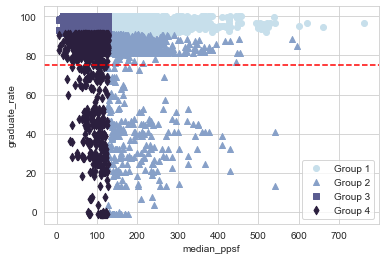

In [54]:
mean_median_ppsf = df['median_ppsf'].mean()
mean_graduate_rate = df['graduate_rate'].mean()

conditions = [
    (df['median_ppsf'] > mean_median_ppsf) & (df['graduate_rate'] > mean_graduate_rate),
    (df['median_ppsf'] > mean_median_ppsf) & (df['graduate_rate'] <= mean_graduate_rate),
    (df['median_ppsf'] <= mean_median_ppsf) & (df['graduate_rate'] > mean_graduate_rate),
    (df['median_ppsf'] <= mean_median_ppsf) & (df['graduate_rate'] <= mean_graduate_rate)
]
values = ['group1', 'group2', 'group3', 'group4']

groups = df.groupby(np.select(conditions, values))
group1_df = pd.DataFrame(groups.get_group('group1'))
group2_df = pd.DataFrame(groups.get_group('group2'))
group3_df = pd.DataFrame(groups.get_group('group3'))
group4_df = pd.DataFrame(groups.get_group('group4'))


### plot
fig, ax = plt.subplots()

color_list = sns.color_palette("ch:s=.25,rot=-.25", n_colors=4)
marker_list = ['o', '^', 's', 'd']

for i, dt in enumerate([group1_df, group2_df, group3_df, group4_df]):
    x = dt['median_ppsf']
    y = dt['graduate_rate']
    ax.scatter(x, y, color=color_list[i], marker=marker_list[i], label='Group {}'.format(i+1))

ax.axhline(y=75, color='red', linestyle='--')

ax.legend()
ax.set_xlabel('median_ppsf')
ax.set_ylabel('graduate_rate')
plt.show()


## Outlier

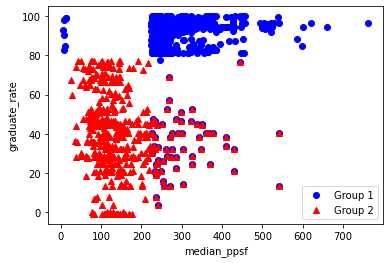

In [15]:
def outiler_row(df,column_name):

    median = df[column_name].median()
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)

    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    return outliers

outlier_median_ppsf=outiler_row(df,column_name='median_ppsf' )
outlier_graduate_rate=outiler_row(df,column_name='graduate_rate' )

# plot
fig, ax = plt.subplots()
color_list = ['blue', 'red',]
marker_list = ['o', '^']

for i, dt in enumerate([outlier_median_ppsf,outlier_graduate_rate]):
    x = dt['median_ppsf']
    y = dt['graduate_rate']
    ax.scatter(x, y, color=color_list[i], marker=marker_list[i], label='Group {}'.format(i+1))

ax.legend()
ax.set_xlabel('median_ppsf')
ax.set_ylabel('graduate_rate')
plt.show()

## Divide into two datasets with 75 as the threshold

In [13]:
# select graduate_rate in (0,75)
small75 = df[(df['graduate_rate']<75) & (df['graduate_rate']>0)]
small75.to_csv('TX_data/small75.csv')

# select graduate_rate >= 75
df = df[df['graduate_rate']>=75]
df.to_csv('TX_data/large75.csv')

## Divide data based on time node/ district

In [14]:
# apply to all school years up until 2022 (original)
df1 = df.copy()
df1['distname'] = df1['distname'].cat.codes

# apply to all school years up until 2019 (to remove the impact of COVID-19)
df2 = df[(df['year']<=2019) & (df['year']>=2015) ]
df2['distname'] = df2['distname'].cat.codes

# apply to all school years up until 2022 but focus on the 
key_district=pd.read_excel('TX_data/key-TX School Districts.xlsx')
district_list=key_district.loc[key_district['RANK of Impact holdings']!='No Impact Holdings','Credit\nName'].to_list()
district_list =[ x.replace('Independent School District','ISD')  for x in district_list]
print(district_list)

df3 = df[(df['year']>=2015) & (df['year']<2022)]
df3 = df[df['distname'].str.lower().isin([x.lower() for x in district_list])]
df3['distname'] = df3['distname'].cat.codes

# 
df['distname'] = df['distname'].cat.codes

['Dallas ISD', 'Fort Worth ISD', 'San Antonio ISD', 'Elgin ISD', 'Nacogdoches ISD', 'Brownsville ISD', 'Galena Park ISD', 'Laredo ISD', 'Kingsville ISD', 'Poteet ISD', 'Houston ISD']


In [15]:
# Reoder columns
df = df[['year', 'zipcode', 'DISTRICT', 'distname',
    'graduate_rate', 'scale_graduate_rate', 'Average 4yr Graduation Rate', 'grad_rate_change',
    'median_ppsf','scale_median_ppsf', 'Year-over-year change%', 'Rolling 4-yr Change%', 'Average 4yr PPSF',
        'home_price_change_1_lag', 'home_price_change_2_lag','home_price_change_3_lag'
    ]]  # , 'area', 

# EDA
- correlation, heatmap
- pairplot

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9394 entries, 0 to 11058
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   year                         9394 non-null   int64   
 1   zipcode                      9394 non-null   category
 2   DISTRICT                     9394 non-null   category
 3   distname                     9394 non-null   int16   
 4   graduate_rate                9394 non-null   float64 
 5   scale_graduate_rate          9394 non-null   float64 
 6   Average 4yr Graduation Rate  4943 non-null   float64 
 7   grad_rate_change             3622 non-null   float64 
 8   median_ppsf                  9394 non-null   float64 
 9   scale_median_ppsf            9394 non-null   float64 
 10  Year-over-year change%       9129 non-null   float64 
 11  Rolling 4-yr Change%         8568 non-null   float64 
 12  Average 4yr PPSF             8568 non-null   float64 
 13  ho

In [17]:
df.describe()

,year,distname,graduate_rate,scale_graduate_rate,Average 4yr Graduation Rate,grad_rate_change,median_ppsf,scale_median_ppsf,Year-over-year change%,Rolling 4-yr Change%,Average 4yr PPSF,home_price_change_1_lag,home_price_change_2_lag,home_price_change_3_lag
count,9394.000000,9394.000000,9394.000000,9394.000000,4943.000000,3622.000000,9394.000000,9394.000000,9129.000000,8568.000000,8568.000000,7259.000000,5995.000000,4760.000000
mean,2018.151586,356.394188,93.566904,0.196255,93.271733,0.284711,125.693101,0.059196,14.729700,35.380319,113.733112,8.970472,18.048172,27.878217
std,2.007707,206.789125,5.240087,0.381995,5.418916,1.826897,56.143690,0.897670,61.041700,103.388135,48.768477,7.358977,12.960115,19.098981
min,2015.000000,1.000000,75.000000,-1.157248,54.050000,-5.331718,6.400000,-1.848157,-94.870087,-91.172864,18.150370,-63.600821,-59.921223,-59.011655
25%,2016.000000,179.000000,90.700000,-0.012739,90.675000,-0.203614,92.480527,-0.471833,2.633098,15.085118,84.078645,5.196194,10.857933,16.966116
50%,2018.000000,341.000000,94.800000,0.286146,94.775000,0.106073,116.682943,-0.084865,8.403228,26.659970,105.236731,8.253197,16.230139,24.776551
75%,2020.000000,511.000000,97.600000,0.490262,97.275000,0.672878,144.163202,0.354511,16.687634,40.766205,130.006944,11.599988,22.707752,34.797369
max,2021.000000,782.000000,100.000000,0.665219,100.000000,39.548023,761.379864,10.223063,4143.589744,8132.700026,636.750358,120.520870,155.038515,203.096910


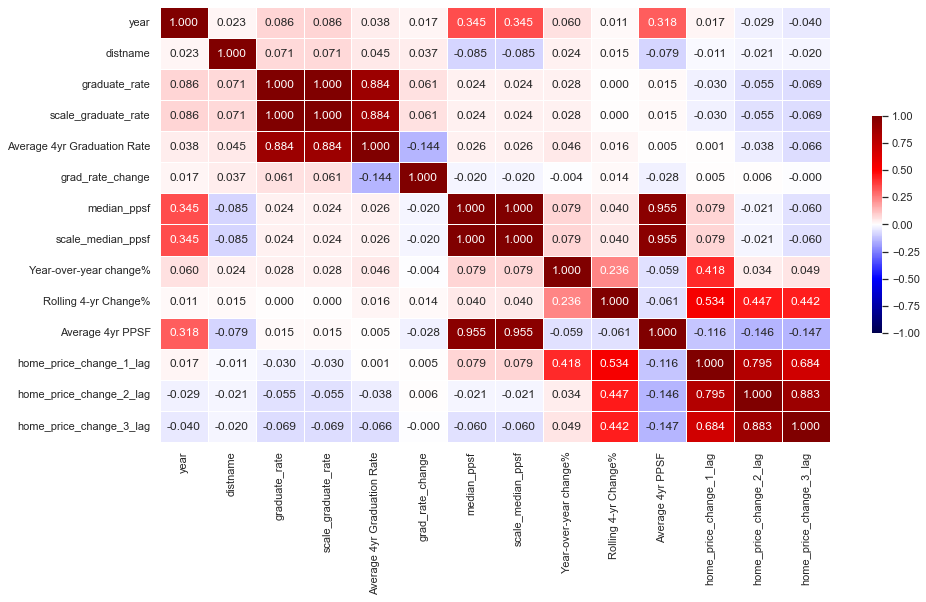

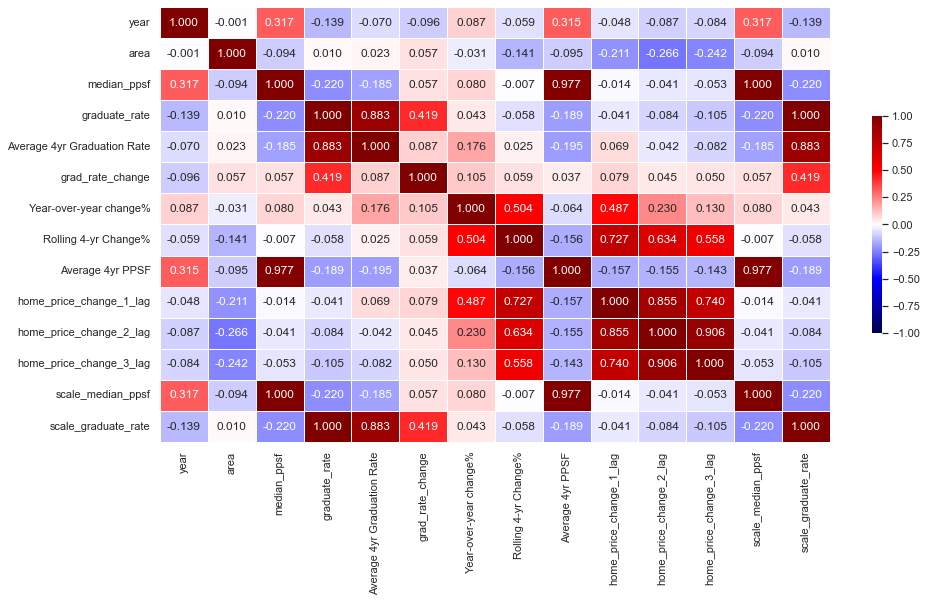

In [18]:
# heatmap
def corr(df):
    sns.set(font_scale=1.)
    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(df.corr() , 
            cmap='seismic', annot=True, fmt=".3f", vmin=-1, vmax=1, center=0,
            square=False, linewidths=.7, cbar_kws={"shrink": .5});

corr(df)
corr(small75)
# corr(df2)
# corr(df3)

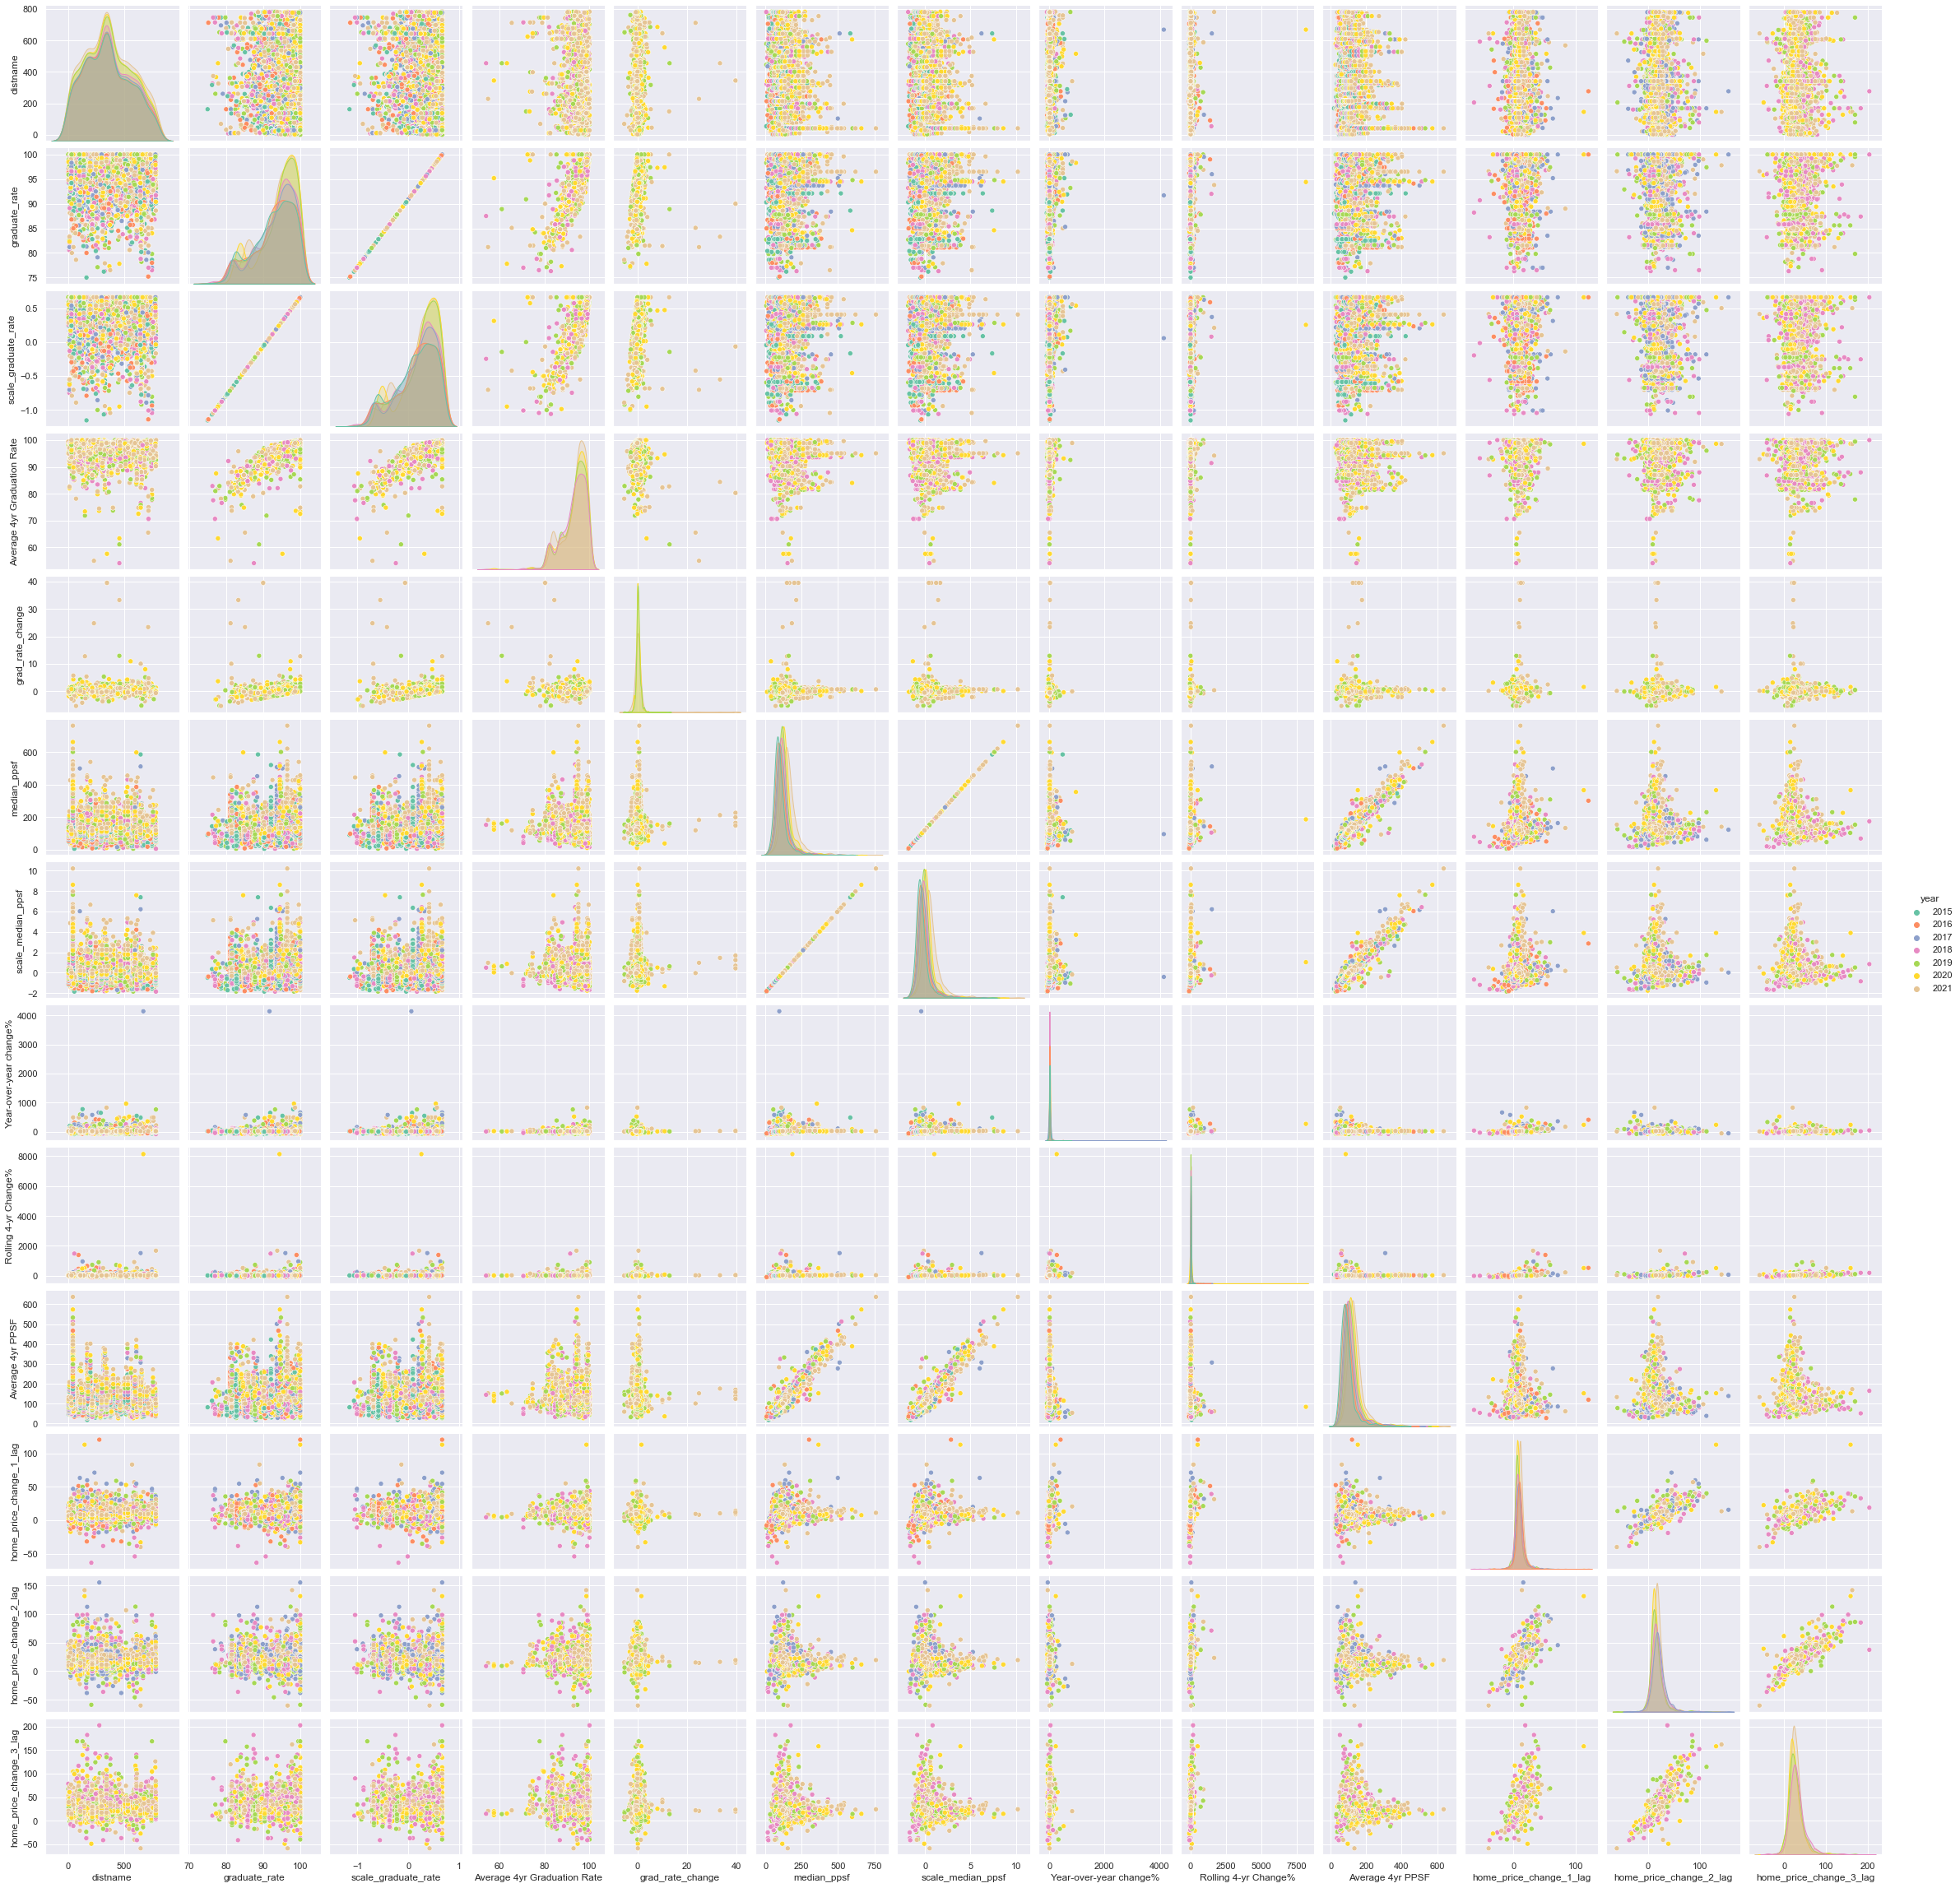

In [19]:
sns.pairplot(df,hue='year',palette="Set2")

# Model - Feature Selection

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def print_metric(y_test, y_pred,r2_filter):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    
    if (r2<0) and (r2_filter=='Yes'):
        print('r2<0')
        return None
    else:
        print(f"MSE: {mse}")
        print(f"R^2: {r2}")
        print("RMSE:", rmse)
        print("MAE:", mae)


def t_data(data,x_col,y_col):
    time_stamps = sorted(list(set(data['year'])))
    train_end_idx = math.floor(len(time_stamps) * 0.8)
    train_year = time_stamps[:train_end_idx]
    test_year = time_stamps[train_end_idx:]

    train_data = data[data['year'].isin(train_year)]
    test_data = data[data['year'].isin(test_year)]

    X_train = train_data[x_col]
    y_train = train_data[y_col]

    X_test = test_data[x_col]
    y_test = test_data[y_col]
    
    return X_train,y_train,X_test,y_test


In [21]:
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def allmodel(data,x_col,y_col,model_type,r2_filter):
    data=data.copy()
    
    print('-----------------------------------',model_type,'-----------------------------------')
    
    
    if model_type in ['randomforest','linear','decision']:
        data=data.ffill().bfill()
        
        X_train,y_train,X_test,y_test=t_data(data,x_col,y_col)
        print('Feature: ', X_train.columns)
        if model_type=='randomforest':
            model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            print('feature importance: ',model.feature_importances_)
            feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})

        if model_type=='linear':
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            print('coef: ',model.coef_)
            print('intercept: ',model.intercept_)
            
            feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.coef_}) 

        if model_type=='decision':
            model = DecisionTreeRegressor()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            print('feature importance: ',model.feature_importances_)
            feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
    
        sns.set(font_scale=1.2, style='whitegrid')
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df.sort_values('Importance', ascending=False), palette='pastel')
        plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
        plt.ylabel('Feature', fontsize=12, fontweight='bold')
        plt.title('Feature Importance Plot', fontsize=14, fontweight='bold')
        plt.show()        
            
    if model_type=='xgb':
        X_train,y_train,X_test,y_test=t_data(data,x_col,y_col)
        
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
        xgb_model = xgb.train(params, dtrain)

        dtest = xgb.DMatrix(X_test, enable_categorical=True)
        y_pred = xgb_model.predict(dtest)

        # Plot feature importance
        fig, ax = plt.subplots(figsize=(12,8))
        xgb.plot_importance(xgb_model, ax=ax)
        plt.show()

    print_metric(y_test, y_pred,r2_filter)


----------------------------------- randomforest -----------------------------------
Feature:  Index(['year', 'zipcode', 'DISTRICT', 'graduate_rate', 'scale_graduate_rate',
       'Average 4yr Graduation Rate', 'grad_rate_change'],
      dtype='object')
feature importance:  [0.05454551 0.48383025 0.29149135 0.02697345 0.0286593  0.05332989
 0.06117024]


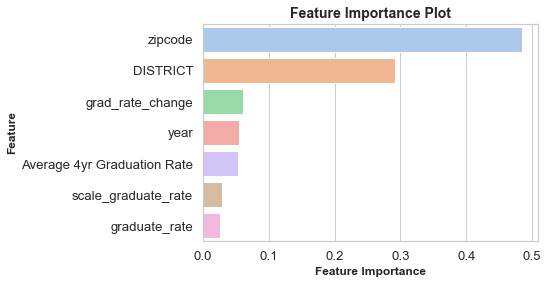

MSE: 2677.8988699535344
R^2: 0.2779453448419873
RMSE: 51.748419009217415
MAE: 36.721906594641524
----------------------------------- linear -----------------------------------
Feature:  Index(['year', 'zipcode', 'DISTRICT', 'graduate_rate', 'scale_graduate_rate',
       'Average 4yr Graduation Rate', 'grad_rate_change'],
      dtype='object')
coef:  [ 6.17421201e+00 -2.54551812e-03  9.65936548e-05 -1.89812241e-01
 -1.38370621e-02 -5.47931872e-02  4.14877058e-02]
intercept:  -12131.846030092343


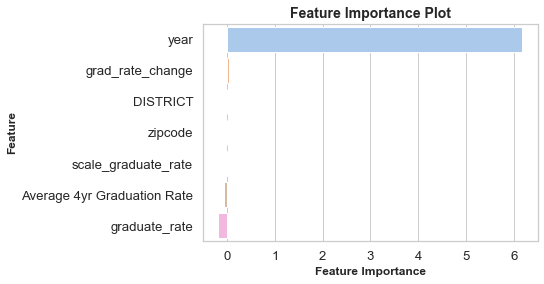

MSE: 3849.2671562240744
R^2: -0.03789627766886694
RMSE: 62.04246252546778
MAE: 37.37224299955742
----------------------------------- decision -----------------------------------
Feature:  Index(['year', 'zipcode', 'DISTRICT', 'graduate_rate', 'scale_graduate_rate',
       'Average 4yr Graduation Rate', 'grad_rate_change'],
      dtype='object')
feature importance:  [0.05440037 0.52225847 0.23817345 0.03174025 0.03082253 0.06381675
 0.05878819]


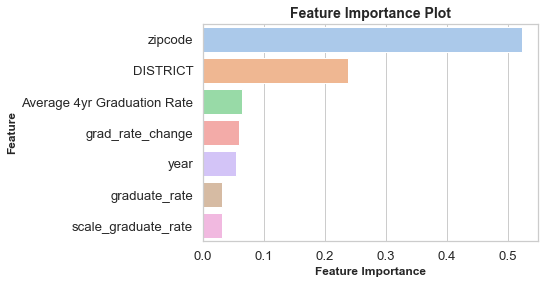

MSE: 2727.857528297921
R^2: 0.2644747533167596
RMSE: 52.22889553013658
MAE: 37.84557353316538
----------------------------------- xgb -----------------------------------


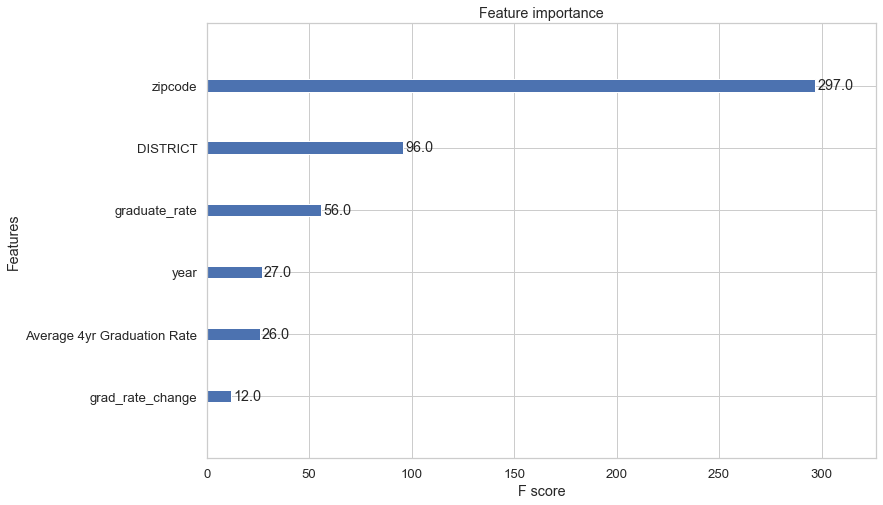

MSE: 2973.905092922799
R^2: 0.19813177396789117
RMSE: 54.533522652794026
MAE: 37.992000224001586


In [25]:
# y_all=['median_ppsf', 'Year-over-year change%', 'Rolling 4-yr Change%','Average 4yr PPSF', 
# 'home_price_change_1_lag', 'home_price_change_2_lag','home_price_change_3_lag','scale_median_ppsf']

x_col=['year', 'zipcode', 'DISTRICT', 
       'graduate_rate', 
       'scale_graduate_rate', 'Average 4yr Graduation Rate',
       'grad_rate_change',] #'distname',
y_col='median_ppsf'

for model_type in ['randomforest','linear','decision','xgb']:
    allmodel(df,x_col,y_col,model_type,r2_filter='No')